<div align="right" style="text-align: right"><i>Peter Norvig<br>Aug 2018</i></div>

# Tour de 538


You are the coach for a bicycle racing team, one of 20 teams entered in the [Tour de FiveThirtyEight](https://fivethirtyeight.com/features/can-you-win-the-tour-de-fivethirtyeight/) time trial, which has these  rules:

>*Each team rides as a group throughout the course at some fixed pace, specified by that team’s coach. Teams that can’t maintain their pace are said to have **cracked,** and don’t **finish** the course.
The team that finishes the course with the fastest pace is  the winner.
Teams ride the course one at a time. After each team completes its attempt, the next team quickly consults with its coach (who assigns a pace) and then begins its ride. Coaches are aware of the results of all previous teams when choosing their own team’s pace.
Assume that all teams are of equal ability: At any given pace, they have the exact same probability of cracking, and the faster the pace, the greater the probability of cracking. Teams’ chances of cracking are independent, and each team’s coach knows exactly what a team’s chances of cracking are for each pace. You are the first team to attempt the course. To maximize your chances of winning, what’s the probability that your team will finish the course? What’s the probability you’ll ultimately win? How about the other teams?*

In [1]:
# PRELIMINARIES
%matplotlib inline
import matplotlib.pyplot as plt
import random
from functools import lru_cache
from collections import Counter

# Analysis

At first it might seem like we don't have enough information: we don't know the relation between probability of finishing and the actual pace/speed.  But after a little thought, it is clear we don't need to know how fast each team goes. Probability of finishing may not be related linearly to speed, but whatever the function that relates probability of finishing to speed, it is **monotonic**: the the faster the pace, the lower the probability of finishing. Thus, the team that chooses the lowest probability and actually finishes will be the winner (even if we don't know their speed/time).

Let's start with **a simpler case: just two teams**.  The first team chooses a probability $p$ of finishing. If the first team cracks, the second team chooses probability 1 of finishing, rides the race at a nice leisurly pace, and wins. If the first team finishes, the second team chooses probability $p - 𝜖$ of finishing, where 𝜖 is an arbitrarily small number; that gives them an ever-so-slightly-faster pace than the first team. But  let's just write $p$ instead of $p - 𝜖$, with the understanding that the $𝜖$ is so small that it doesn't matter for our calculations&mdash;another way of saying this is that a tie goes to the team that goes later. So the first team wins if they finish and the second team doesn't, and since "chances of cracking are independent," that joint event has probabilty $p (1 - p)$. What pace $p$ maximizes that? I'm going to enumerate 1001 different $p$ values and find the one that maximizes $p (1 - p)$:

In [2]:
probabilities = [x/1000 for x in range(1001)] # [0.000, 0.001, 0.002, ... 1.000]

max(probabilities, key=lambda p: p * (1 - p))

0.5

That says the first team's best choice is a pace that gives them a probability 0.5 of finishing. They win the race with probability 0.5 &times; (1 - 0.5) = 0.25; the second team wins with probability 0.75. There is value in the information gained by going second!  

Now for **the case of $n$ teams**. The first team wins if they finish (with probability $p$), and if *all* the other teams crack (with probability $(1 - p)^{n - 1}$, assuming they also choose pace $p$).  All together, that's $p(1 - p)^{n - 1}$. Again, I can try out all the  probabilities in `probabilities` and see which is the best pace for the first team, for various values of `n` teams in the race:

In [3]:
def best_pace(n) -> float:
    """The pace p with highest probability of winning for the first of `n` teams."""
    return max(probabilities, key=lambda p: win_prob(p, n))

def win_prob(p, n) -> float:
    """Probability of first team winning if all n teams choose pace `p`."""
    return p * (1 - p) ** (n - 1)
    
{n: best_pace(n) for n in range(1, 7)}

{1: 1.0, 2: 0.5, 3: 0.333, 4: 0.25, 5: 0.2, 6: 0.167}

Notice a pattern? It looks like `best_pace(n)` is $1/n$. But can we prove it?  

# Using Calculus to Find  Best Pace 

Calculus says that the extrema (maximum or minimum) of a function is where the derivative is zero. What's the derivative of $p (1 - p)^{n - 1}$?

$$\frac{d}{dp} p (1 - p)^{n - 1} =  (1 - p)^{n - 2} (1 - n p) $$

This is indeed zero  when  $p = 1/n$.  We can check that `best_pace(n)` agrees with `1 / n` (to within 3 decimal places):

In [4]:
for n in range(1, 21):
    assert abs(best_pace(n) - 1/n) < 0.001 

We now know how every race will play out:
- The first of $n$ teams chooses pace $p = 1/n$.
- If they crack, it is like starting a race with $n - 1$ teams, and the next team chooses pace $1/(n - 1)$.
- If they finish, every team from then on will choose a pace that is $𝜖$ faster than the previous finisher.
- The only way for the first team to win is if every other chooses $p$ and cracks.
- This confirms that the win probability for the first team is $p(1 - p)^{n - 1}$, where $p = 1/n$.

# Tabulating Results

We can print a table of three columns: the number of teams $n$, the best pace for the first of $n$ teams, and the probability that the first team will win if it adopts that pace:


In [5]:
print(' n    pace    P(win)')
for n in range(1, 21):
    print(f'{n:2d}  {1 / n:0.5f}  {win_prob(1 / n, n):0.5f}')

 n    pace    P(win)
 1  1.00000  1.00000
 2  0.50000  0.25000
 3  0.33333  0.14815
 4  0.25000  0.10547
 5  0.20000  0.08192
 6  0.16667  0.06698
 7  0.14286  0.05665
 8  0.12500  0.04909
 9  0.11111  0.04330
10  0.10000  0.03874
11  0.09091  0.03505
12  0.08333  0.03200
13  0.07692  0.02944
14  0.07143  0.02726
15  0.06667  0.02538
16  0.06250  0.02374
17  0.05882  0.02230
18  0.05556  0.02102
19  0.05263  0.01989
20  0.05000  0.01887


# Visualizing Results

Here is a plot for various numbers of teams of the probability of the first team winning, as a function of the pace that the first team chooses.  Each curve is for a different number of teams participating in the race (as shown by the label number).

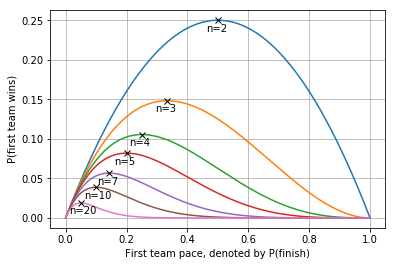

In [6]:
def annotate(x, y, text):
    plt.text(x - 0.04, y - 0.014, text)
    plt.plot([x], [y], 'kx')
    
for n in [2, 3, 4, 5, 7, 10, 20]:
    plt.plot(probabilities, [win_prob(p, n) for p in probabilities])
    annotate(1 / n, win_prob(1 / n, n), f'n={n}')
plt.xlabel('First team pace, denoted by P(finish)')
plt.ylabel('P(first team wins)')
plt.grid(True);

# Calculation of Win Probability for All Teams

What is the full probability distribution of winners over all the teams? I'll define `winners(teams)` to answer the question, where `teams` is a tuple of teams, such as `(1, 2, 3, 4)`.  Here's how it works:
- `winners(teams)` gives the probability of winning the race for each team. The result is a `Dist`, a probability distribution of `{team: probability}` pairs. For example, we want `winners((1, 2))` to return `Dist({1: 0.25, 2: 0.75})`.
- A recursive call to `winners(teams, leader, leader_pace)` means that `teams` is the collection of teams who have not raced yet, `leader` is the fastest finishing team among those who have already raced, and `leader_pace` is the pace that the leader rode.
- If there are no `teams` remaining to race, then the winner (with probability 1) is the `leader` so far.
- If there are $n$ teams left to race, then the next team up will choose a pace $p$ that is the faster of $1/n$ and the current leader's pace. 
- There are two possible cases to consider:
  - That `team` finishes, with probability `p`, and becomes the new leader. The probability distribution in this case is computed by a recursive call `winners(other_teams, team, p)`.
  - That `team` cracks, with probability `1 - p`, and the leader is unchanged. The probability distribution  in this case is computed by a recursive call `winners(other_teams, leader, leader_pace)`.
- We combine the two cases, weighted by their probability.


In [7]:
class Dist(Counter):
    """A {outcome: frequency} distribution. Can multiply values by a constant."""
    def __mul__(self, c): return Dist({x: c * self[x] for x in self})
    __rmul__ = __mul__
    
@lru_cache(None)
def winners(teams, leader=None, leader_pace=1) -> Dist:
    """Calculate the probability of each team winning."""
    if not teams:
        return Dist({leader: 1})
    else:
        team, other_teams = teams[0], teams[1:]
        p = min(1/len(teams), leader_pace)
        finish = winners(other_teams, team, p)
        crack  = winners(other_teams, leader, leader_pace)
        return Dist(p * finish + (1 - p) * crack)
    


In [8]:
winners((1, 2))

Dist({2: 0.75, 1: 0.25})

# Simulation of Winners

As a check, let's do a simulation where each team chooses their `pace`, and we randomly see if they crack, and eventually see who wins the race. Repeat that for a million races and count the winners. I'll define `race` to be as similar to `winners` as possible, but to follow one of the two paths (finish or crack) at random, rather than following both.

In [9]:
def race(teams, leader=None, leader_pace=1):
    "Simulate a single race with given teams; return the winning team."
    if not teams:
        return leader
    else:
        team, other_teams = teams[0], teams[1:]
        p = min(1/len(teams), leader_pace)
        return (race(other_teams, team, p) if random.random() < p else
                race(other_teams, leader, leader_pace))

def races(teams, repeat=1000000):
    "Simulate `repeat` races with given teams; return a probability distribution over winners."
    counts = Counter(race(teams) for _ in range(repeat))
    return Dist({team: counts[team] / repeat for team in teams})

In [10]:
races((1, 2))

Dist({1: 0.249669, 2: 0.750331})

# Comparison of Calculation to Simulation

Now we can compare the  theoretical calculated results with the simulated results:

  n  Calcul  Simul     Delta
  1  0.0189  0.0192  -0.0003
  2  0.0199  0.0200  -0.0001
  3  0.0210  0.0211  -0.0001
  4  0.0223  0.0223  +0.0000
  5  0.0237  0.0237  +0.0000
  6  0.0253  0.0253  -0.0000
  7  0.0270  0.0270  -0.0000
  8  0.0290  0.0289  +0.0001
  9  0.0313  0.0313  +0.0001
 10  0.0340  0.0340  +0.0000
 11  0.0370  0.0371  -0.0001
 12  0.0406  0.0406  -0.0001
 13  0.0448  0.0446  +0.0001
 14  0.0498  0.0499  -0.0001
 15  0.0560  0.0561  -0.0000
 16  0.0639  0.0639  +0.0000
 17  0.0742  0.0739  +0.0003
 18  0.0889  0.0889  -0.0001
 19  0.1126  0.1122  +0.0003
 20  0.1799  0.1801  -0.0003


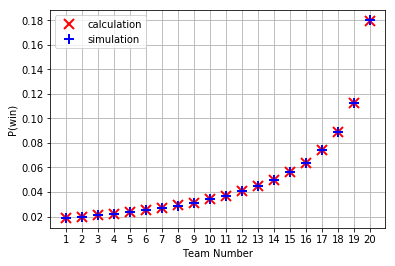

In [11]:
def compare(teams=range(1, 21)):
    """Print and plot comparison between `races` simulation and `winners` calculation."""
    wins = winners(teams)
    sims = races(teams)
    print(f'  n  Calcul  Simul     Delta')
    for team in teams:
        print(f'{team:3d}  {wins[team]:.4f}  {sims[team]:.4f}  {wins[team]-sims[team]:+.4f}')
    plt.plot(teams, [wins[i] for i in teams], 'rx', label='calculation', ms=10, mew=2)
    plt.plot(teams, [sims[i] for i in teams], 'b+', label='simulation',  ms=10, mew=2)
    plt.xticks(ticks=teams); plt.grid(True);
    plt.xlabel('Team Number'); plt.ylabel('P(win)'); plt.legend()

compare()

We see there is excellent agreement The `×` and `+` markers are all on top of each other. The agreement extends to a different number of teams:

  n  Calcul  Simul     Delta
  1  0.0387  0.0387  +0.0001
  2  0.0433  0.0434  -0.0001
  3  0.0489  0.0489  -0.0000
  4  0.0561  0.0554  +0.0007
  5  0.0653  0.0657  -0.0004
  6  0.0775  0.0769  +0.0006
  7  0.0945  0.0948  -0.0003
  8  0.1198  0.1198  +0.0001
  9  0.1629  0.1633  -0.0004
 10  0.2929  0.2931  -0.0002


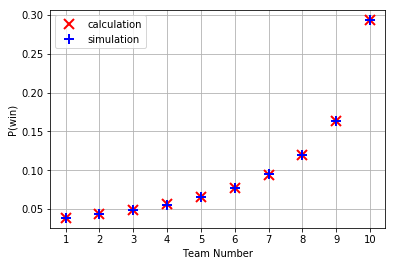

In [12]:
compare(range(1, 11))